In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

# Step 1: Retrieve Historical Data
ticker = "AAPL"  # example ticker
data = yf.download(ticker, start="2020-01-01", end="2023-01-01")
data = data['Close'].reset_index()
data.columns = ['date', 'value']

# Step 2: Preprocess the Data
scaler = MinMaxScaler()
data['value'] = scaler.fit_transform(data[['value']])

data['time_idx'] = pd.RangeIndex(len(data))
data['group'] = 0

# Convert to numpy array
values = data['value'].values

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 90
X, y = create_sequences(values, seq_length)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

#### TSMIXER

class TSMixer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TSMixer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = seq_length
hidden_size = 50
output_size = 1

model = TSMixer(input_size, hidden_size, output_size)

[*********************100%%**********************]  1 of 1 completed


In [8]:
values

array([0.15085277, 0.14505529, 0.14976075, 0.14696135, 0.15649137,
       0.16927753, 0.17066729, 0.18383068, 0.17533306, 0.17267259,
       0.18041574, 0.18734493, 0.1830564 , 0.18529994, 0.18833764,
       0.18651102, 0.16792745, 0.18528007, 0.19848314, 0.19754999,
       0.16903929, 0.16735166, 0.18758317, 0.19274529, 0.20021045,
       0.18992596, 0.19294378, 0.18909205, 0.2041615 , 0.19953542,
       0.19969428, 0.18788097, 0.19705363, 0.190462  , 0.17606765,
       0.14654436, 0.12649154, 0.13556496, 0.09758373, 0.09726605,
       0.14779519, 0.12895351, 0.15559791, 0.13610106, 0.12837772,
       0.08299089, 0.12105149, 0.1013759 , 0.04737229, 0.1064189 ,
       0.03542004, 0.05656483, 0.04427503, 0.04052257, 0.00966905,
       0.        , 0.04469198, 0.0419918 , 0.06764351, 0.04639945,
       0.0604364 , 0.05940397, 0.03283898, 0.04082037, 0.03383169,
       0.07564478, 0.06960907, 0.08279233, 0.08660432, 0.09704768,
       0.12444655, 0.11924474, 0.12373183, 0.11600849, 0.10435

In [5]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    
    # calculate loss
    loss = criterion(outputs, y_train)
    
    # backpropagate
    loss.backward()
    
    # update weights
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

c:\Users\igor-\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([532])) that is different to the input size (torch.Size([532, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0896
Epoch [20/100], Loss: 0.0807
Epoch [30/100], Loss: 0.0754
Epoch [40/100], Loss: 0.0706
Epoch [50/100], Loss: 0.0664
Epoch [60/100], Loss: 0.0626
Epoch [70/100], Loss: 0.0593
Epoch [80/100], Loss: 0.0566
Epoch [90/100], Loss: 0.0544
Epoch [100/100], Loss: 0.0526


tensor([[0.1509, 0.1451, 0.1498,  ..., 0.1576, 0.1703, 0.1800],
        [0.1451, 0.1498, 0.1470,  ..., 0.1703, 0.1800, 0.1728],
        [0.1498, 0.1470, 0.1565,  ..., 0.1800, 0.1728, 0.1653],
        ...,
        [0.9178, 0.9430, 0.9545,  ..., 0.6019, 0.6089, 0.6301],
        [0.9430, 0.9545, 0.9215,  ..., 0.6089, 0.6301, 0.5874],
        [0.9545, 0.9215, 0.8938,  ..., 0.6301, 0.5874, 0.5993]])

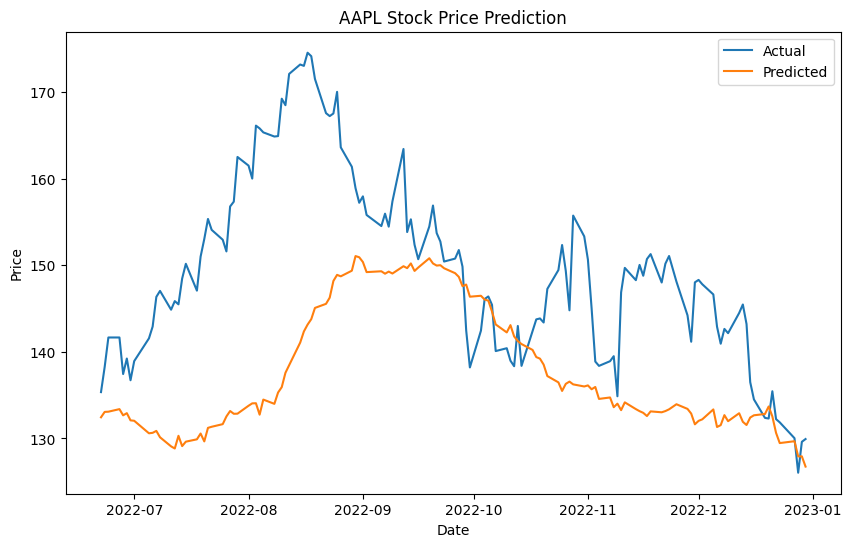

In [3]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(data['date'][len(data) - len(y_test):], y_test, label='Actual')
plt.plot(data['date'][len(data) - len(predictions):], predictions, label='Predicted')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Forecast

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\igor-\AppData\Local\Temp\ipykernel_6728\3832827278.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='ffill', inplace=True)
C:\Users\igor-\AppData\Local\Temp\ipykernel_6728\3832827278.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='bfill', inplace=True)
10:27:50 - cmdstanpy - INFO - Chain [1] start processing
10:27:50 - cmdstanpy - INFO - Chain [1] done processing
10:27:50 - cmdstanpy - INFO - Chain [1] start processing
10:27:51 - cmdstanpy - INFO - Chain [1] done processing
10:27:51 - cmdstanpy - INFO - Chain [1] start processing


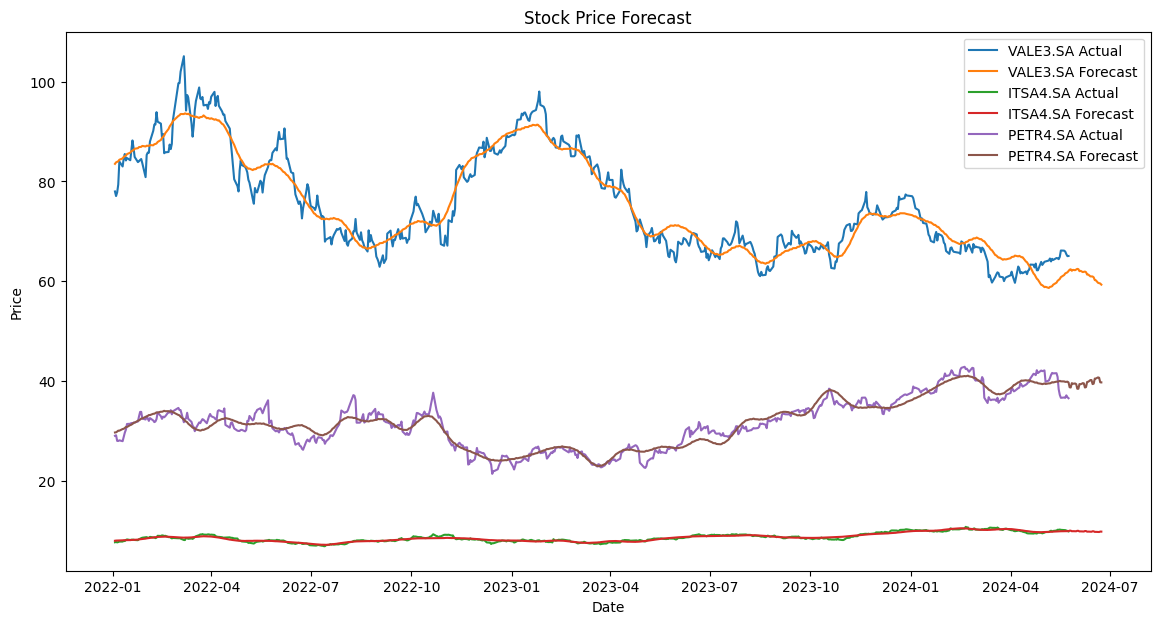

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Step 2: Download historical data
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start="2022-01-01", end="2024-05-25")


close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

close_prices.fillna(method='ffill', inplace=True)
close_prices.fillna(method='bfill', inplace=True)

models = {}
forecasts = {}
forecast_period = 30  # days to forecast

for ticker in tickers:
    df = close_prices[[ticker]].reset_index()
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    models[ticker] = model
    forecasts[ticker] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Step 5: Make predictions
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(close_prices[ticker], label=f"{ticker} Actual")
    plt.plot(forecasts[ticker]['ds'], forecasts[ticker]['yhat'], label=f"{ticker} Forecast")

plt.legend()
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [30]:
import datetime
from datetime import timedelta
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
to_date

'2024-07-01'

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
C:\Users\igor-\AppData\Local\Temp\ipykernel_6728\1245937027.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='ffill', inplace=True)
C:\Users\igor-\AppData\Local\Temp\ipykernel_6728\1245937027.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='bfill', inplace=True)
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] done processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] done processing
14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] done processing


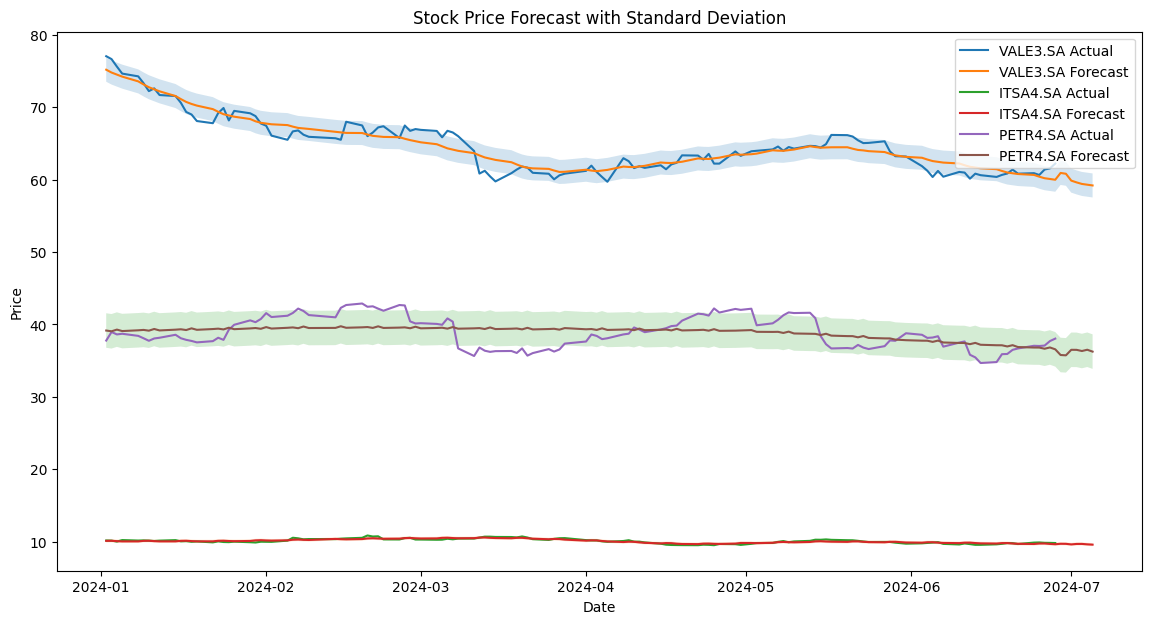

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Igor do futuro isso pega a data de ontem bjs
import datetime
from datetime import timedelta
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start="2024-01-01", end=to_date)

#Vamor treinar esse baguio toda vez que rodar

close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

close_prices.fillna(method='ffill', inplace=True)
close_prices.fillna(method='bfill', inplace=True)

models = {}
forecasts = {}
forecast_period = 7  # Tempo de previsão Escolhe um valor normal IGOOR

for ticker in tickers:
    df = close_prices[[ticker]].reset_index()
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    models[ticker] = model
    forecasts[ticker] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    forecast['std'] = (close_prices[ticker].rolling(window=22).std().iloc[-1])*2 #Escolhe 3 desvios 1 ou qualquer coisa
    forecast['yhat_upper_std'] = forecast['yhat'] + forecast['std']
    forecast['yhat_lower_std'] = forecast['yhat'] - forecast['std']
    forecasts[ticker] = forecast

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(close_prices[ticker], label=f"{ticker} Actual")
    plt.plot(forecasts[ticker]['ds'], forecasts[ticker]['yhat'], label=f"{ticker} Forecast")
    plt.fill_between(forecasts[ticker]['ds'], forecasts[ticker]['yhat_lower_std'], forecasts[ticker]['yhat_upper_std'], alpha=0.2)

plt.legend()
plt.title('Stock Price Forecast with Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

df['MW2'] = zscore(df['MW'], window=50)

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime

# Define the date range
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

# Define the tickers
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]

# Download the data
data = {ticker: yf.download(ticker, start="2023-07-01", end=to_date) for ticker in tickers}

# Prepare the close prices DataFrame
close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
close_prices.fillna(method='ffill', inplace=True)
close_prices.fillna(method='bfill', inplace=True)

# Forecasting parameters
forecast_period = 7

# Initialize dictionaries to store models and forecasts
models = {}
forecasts = {}

# Train the models and make forecasts
for ticker in tickers:
    df = close_prices[[ticker]].reset_index()
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    
    std_dev = close_prices[ticker].rolling(window=22).std().iloc[-1] * 2
    forecast['std'] = std_dev
    forecast['yhat_upper_std'] = forecast['yhat'] + forecast['std']
    forecast['yhat_lower_std'] = forecast['yhat'] - forecast['std']
    
    models[ticker] = model
    forecasts[ticker] = forecast

# Prepare the data for Excel
excel_data = {}
for ticker in tickers:
    forecast_df = forecasts[ticker][['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_lower_std', 'yhat_upper_std', 'std']]
    forecast_df['type'] = 'prediction'
    actual_df = close_prices[[ticker]].reset_index()
    actual_df.columns = ['ds', 'y']
    actual_df['type'] = 'actual'
    combined_df = pd.concat([actual_df, forecast_df], ignore_index=True)
    combined_df['date'] = combined_df['ds']
    excel_data[ticker] = combined_df

# Save to Excel
file_path = 'stock_forecasts_with_types_and_date.xlsx'
with pd.ExcelWriter(file_path) as writer:
    for ticker in tickers:
        excel_data[ticker].to_excel(writer, sheet_name=ticker, index=False)

file_path

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\igor-\AppData\Local\Temp\ipykernel_32812\2586682799.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='ffill', inplace=True)
C:\Users\igor-\AppData\Local\Temp\ipykernel_32812\2586682799.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='bfill', inplace=True)
15:09:41 - cmdstanpy - INFO - Chain [1] start processing
15:09:41 - cmdstanpy - INFO - Chain [1] done processing
15:09:41 - cmdstanpy - INFO - Chain [1] start processing
15:09:41 - cmdstanpy - INFO - Chain [1] done processing
15:09:41 - cmdstanpy - INFO - Chain [1] start processin

'stock_forecasts_with_types_and_date.xlsx'

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime

# Define the date range
to_date = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

# Define the tickers
tickers = ["VALE3.SA", "ITSA4.SA", "PETR4.SA"]

# Download the data
data = {ticker: yf.download(ticker, start="2024-01-01", end=to_date) for ticker in tickers}

# Prepare the close prices DataFrame
close_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})

# Forecasting parameters
forecast_period = 7

# Initialize dictionaries to store models and forecasts
models = {}
forecasts = {}

# Train the models and make forecasts
for ticker in tickers:
    df = close_prices[[ticker]].reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'])  # Ensure 'ds' is in date format
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    
    std_dev = close_prices[ticker].rolling(window=22).std().iloc[-1] * 2
    forecast['std'] = std_dev
    forecast['yhat_upper_std'] = forecast['yhat'] + forecast['std']
    forecast['yhat_lower_std'] = forecast['yhat'] - forecast['std']
    
    models[ticker] = model
    forecasts[ticker] = forecast

# Prepare the data for Excel
excel_data = {}
for ticker in tickers:
    forecast_df = forecasts[ticker][['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_lower_std', 'yhat_upper_std', 'std']]
    forecast_df['type'] = 'prediction'
    forecast_df['y'] = np.nan
    forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])  # Ensure 'ds' is in date format
    
    actual_df = close_prices[[ticker]].reset_index()
    actual_df.columns = ['ds', 'y']
    actual_df['type'] = 'actual'
    actual_df['yhat'] = np.nan
    actual_df['yhat_lower'] = np.nan
    actual_df['yhat_upper'] = np.nan
    actual_df['yhat_lower_std'] = np.nan
    actual_df['yhat_upper_std'] = np.nan
    actual_df['std'] = np.nan
    actual_df['ds'] = pd.to_datetime(actual_df['ds'])  # Ensure 'ds' is in date format
    
    combined_df = pd.concat([actual_df, forecast_df], ignore_index=True)
    
    excel_data[ticker] = combined_df

# Save to Excel
with pd.ExcelWriter('stock_forecasts_with_types_and_date.xlsx') as writer:
    for ticker in tickers:
        excel_data[ticker].to_excel(writer, sheet_name=ticker, index=False)

print("Forecasts have been saved to stock_forecasts_with_types_and_date.xlsx")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
08:32:27 - cmdstanpy - INFO - Chain [1] start processing
08:32:27 - cmdstanpy - INFO - Chain [1] done processing
08:32:28 - cmdstanpy - INFO - Chain [1] start processing
08:32:28 - cmdstanpy - INFO - Chain [1] done processing
08:32:28 - cmdstanpy - INFO - Chain [1] start processing
08:32:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\igor-\AppData\Local\Temp\ipykernel_13196\3810404620.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['type'] = 'prediction'
C:\Users\igor-\AppData\Local\Temp\ipykernel_13196\3810404620.

Forecasts have been saved to stock_forecasts_with_types_and_date.xlsx


##### Drive API funfando

In [2]:
from Google import Create_Service
from googleapiclient.http import MediaFileUpload
CLIENT_SECRET_FILE = 'client_secrets.json'
API_NAME = 'drive'
API_VERSION ='v3'
SCOPES = ['https://www.googleapis.com/auth/drive']
service = Create_Service(CLIENT_SECRET_FILE,API_NAME,API_VERSION,SCOPES)

folder_id = '1a1GfQsq0rx7gcBds0uOsB9j6h6rh7BLJ'
file_names= ['stock_forecasts_with_types_and_date.xlsx']
mime_types = ['application/vnd.openxmlformats-officedocument.spreadsheetml.sheet']

for file_name, mime_type in zip(file_names,mime_types):
    file_metadata = {
        'name': file_name,
        'parents':[folder_id]
    }

    media=MediaFileUpload('./Saídas_modelos/{0}'.format(file_name),mimetype=mime_type)
    service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()

client_secrets.json-drive-v3-(['https://www.googleapis.com/auth/drive'],)
['https://www.googleapis.com/auth/drive']
drive service created successfully
